In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from astropy.coordinates import Angle
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [135]:
const_c = 3e8   # speed of light [m/s]
frequency = 5e9              # observing frequency [Hz]
wavelength = const_c/frequency # receiving wavelength [metres]

# Funciones

In [69]:
#función profe
def _earthlocation_to_altaz(location, reference_location):
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [70]:
#función profe
def earth_location_to_local(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    return altaz.cartesian.xyz

In [71]:
def calc_R(H,dec):
    
    """
    function to calculate rotation matrix
    """
    
    R = [[np.sin(H), np.cos(H), 0],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec)],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec)]]
    
    return np.array(R)

In [72]:
# Dado la rotación de la tierra, el objeto se "desplaza" en el cielo, por lo tanto se utiliza el
# ángulo horario y declinación para seguir su posición en el cielo

def calc_RR(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [140]:
def h(hObs, gradDec):

    """ 
    Cambia la duración de la observación a X horas
    Muestreo cada 0.1 hrs - 6 min
       """

    observacion_grados = hObs * 15.0
    HA = np.arange(-np.radians(observacion_grados), np.radians(observacion_grados), np.radians(0.1))  # [radianes]
    dec = np.radians(gradDec)
    return HA, dec

In [136]:
def grid_sampling(piximg, uvmax, coverage):
    """ 
    piximg: cantidad de pixeles de la imagen modelo, tiene que ser nxn
    uvmax: Rango maximo de frecuencias que se considera
    uvcoverage: array uv cobertura (x,3)
       """
    # Tamaño de cada celda
    uvcell = 2*uvmax/float(piximg)
    uvgrid = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))

    for i in range(coverage.shape[0]):
      u_pixel = int(np.floor(0.5 + coverage[i,0]/uvcell) + piximg/2)
      v_pixel = int(np.floor(0.5 + coverage[i,1]/uvcell) + piximg/2)
      uvgrid[v_pixel, u_pixel] += 1.0 + 1j*0.0
      
    # S(u,v) = 1 otro caso S=0
    sampling = np.zeros_like(uvgrid)
    posiciones_con_valores = uvgrid != 0
    sampling[posiciones_con_valores] = 1
    return uvgrid, sampling


In [152]:
def baselines(xyz):
    #rehacer con broadcasting e indexacion
    XYZ_baselines = []                                                                  
    for i in range(len(xyz)):                                                         
        for j in range(i+1,len(xyz)):
            XYZ_baselines.append(np.subtract(xyz[i], xyz[j])) # (u,v)
            XYZ_baselines.append(np.subtract(xyz[j], xyz[i])) # (-u,-v)     

    XYZ_baselines = np.array(XYZ_baselines)
    return XYZ_baselines

In [157]:
def coverage(baselines, HA, dec):
    UV_coverage=[]
    for i in range(len(HA)):
        for j in range(len(baselines)):
            R = calc_R(HA[i],dec)
            UV_coverage.append(np.dot(R, baselines[j]))
    
    UV_coverage = np.array(UV_coverage)
    return UV_coverage

# Ejemplo 1

In [74]:
data = [
    [-41.464183, -72.919694, 100],
    [-41.464507, -72.919898, 100],
    [-41.464263, -72.919739, 100],
    [-41.464304, -72.919764, 100],
    [-41.464342, -72.919789, 100],
    [-41.464387, -72.919819, 100],
    [-41.464424, -72.919843, 100],
    [-41.464469, -72.919870, 100],
    [-41.464507, -72.919898, 100]
]

df = pd.DataFrame(data, columns=['Latitud', 'Longitud', 'Altitud'])

In [75]:
abc = EarthLocation.from_geodetic(df['Latitud'], df['Longitud'], df['Altitud'])

In [76]:
reference_location = EarthLocation.from_geodetic(-41.463874, -72.920166,100)


In [168]:
# se transforma a unidades de numero de ondas 
x, y, z = earth_location_to_local(abc, reference_location)/wavelength

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

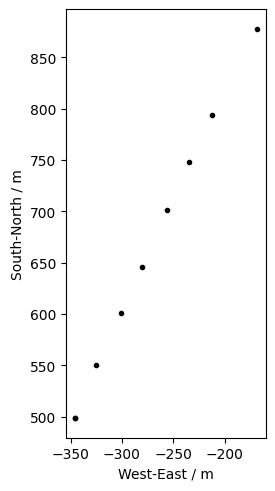

In [169]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(y, x, '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [170]:
stack = np.column_stack((x.value,y.value,z.value))

In [171]:
HA, dec = h(1,45)

In [172]:
UV_coverage = coverage(baselines(stack), HA, dec)

Text(0, 0.5, 'v (m)')

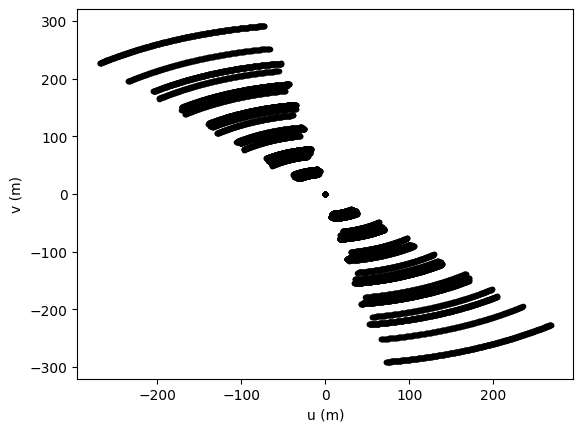

In [173]:
fig, ax = plt.subplots()
ax.scatter(UV_coverage[:, 0],UV_coverage[:,1], c="black", marker=".")
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [27]:
""" plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
    plt.cla()
    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) """

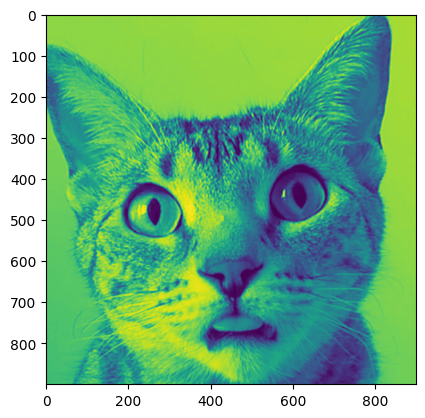

In [84]:
# Cargar la imagen como fuente de luz
image = cv2.imread('cat1.jpg',0)
plt.imshow(image)
plt.show()

In [174]:
fft = np.fft.fft2(image)
ffts = np.fft.fftshift(fft)
ff = np.abs(np.log(ffts))

<function matplotlib.pyplot.show(close=None, block=None)>

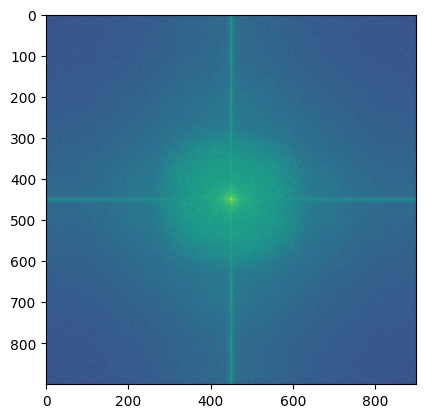

In [175]:
plt.imshow(ff)
plt.show

In [176]:
uvgrid, sampling=grid_sampling(900,4000., UV_coverage)

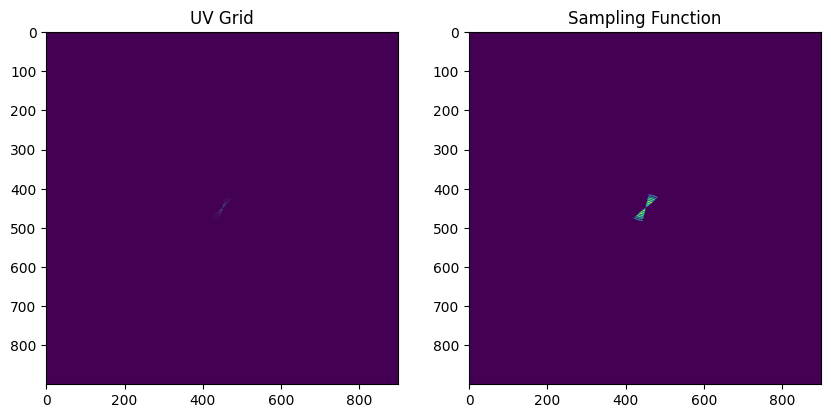

In [177]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('UV Grid');
plt.imshow(uvgrid.real)
plt.subplot(122)
plt.title('Sampling Function');
plt.imshow(sampling.real)

In [178]:
obs = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*sampling)))

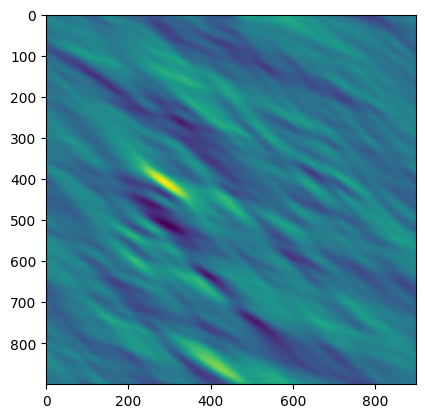

In [179]:
plt.imshow(obs)
plt.show()

In [181]:
# 12 horas de observación
HA, dec = h(12,45)
UV_coverage = coverage(baselines(stack), HA, dec)

In [182]:
uvgrid, sampling=grid_sampling(900,4000., UV_coverage)

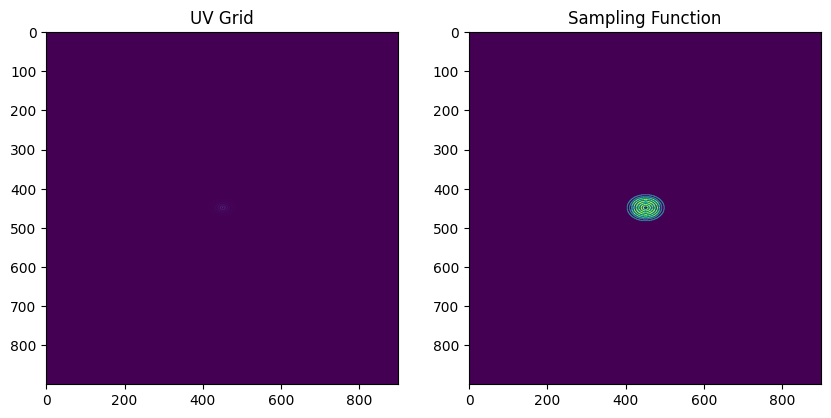

In [183]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('UV Grid');
plt.imshow(uvgrid.real)
plt.subplot(122)
plt.title('Sampling Function');
plt.imshow(sampling.real)

In [184]:
obs = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*sampling)))

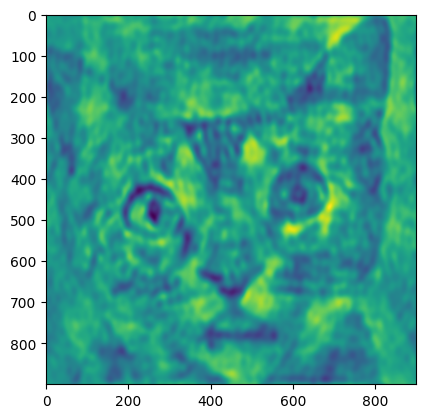

In [185]:
plt.imshow(obs)
plt.show()

# Ejemplo 2

In [187]:
posiciones = [
    (-41.483775, -72.859583, 100),
    (-41.482888, -72.859582, 100),
    (-41.481990, -72.859598, 100),
    (-41.481093, -72.859625, 100),
    (-41.480198, -72.859611, 100),
    (-41.484689, -72.860797, 100),
    (-41.484683, -72.861984, 100),
    (-41.484678, -72.863175, 100),
    (-41.484657, -72.864401, 100),
    (-41.484642, -72.865588, 100),
    (-41.485612, -72.859579, 100),
    (-41.486489, -72.859579, 100),
    (-41.487352, -72.859580, 100),
    (-41.488257, -72.859578, 100),
    (-41.489204, -72.859560, 100),
    (-41.484684, -72.858503, 100),
    (-41.484679, -72.857282, 100),
    (-41.484662, -72.856079, 100),
    (-41.484644, -72.854922, 100),
    (-41.484623, -72.853653, 100)
]
data = np.array(posiciones)
df = pd.DataFrame(data, columns=['Latitud', 'Longitud', 'Altitud'])
reference = [-41.484687, -72.859583]

In [188]:
abc = EarthLocation.from_geodetic(df['Latitud'], df['Longitud'], df['Altitud'])

In [189]:
reference_location = EarthLocation.from_geodetic(reference[0], reference[1], 100)

In [190]:
x, y, z = earth_location_to_local(abc, reference_location)/wavelength

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

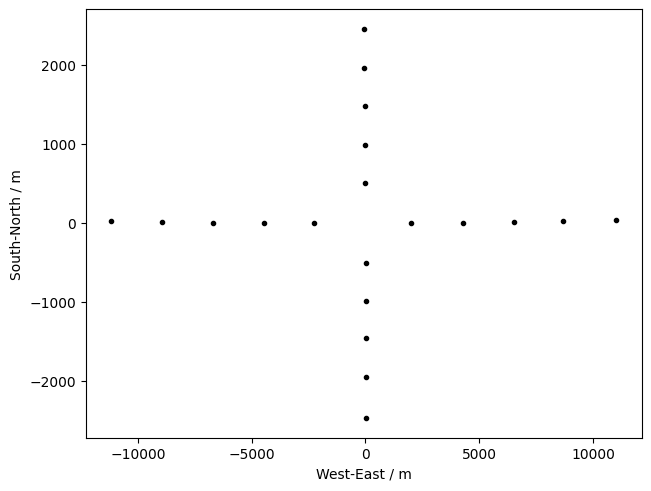

In [191]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(x, y, '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [192]:
ej2 = np.column_stack((x.value,y.value,z.value))

In [204]:
# 12 horas de observación
HA, dec = h(12,45)
UV_coverage = coverage(baselines(ej2), HA, dec)

Text(0, 0.5, 'v (lambda)')

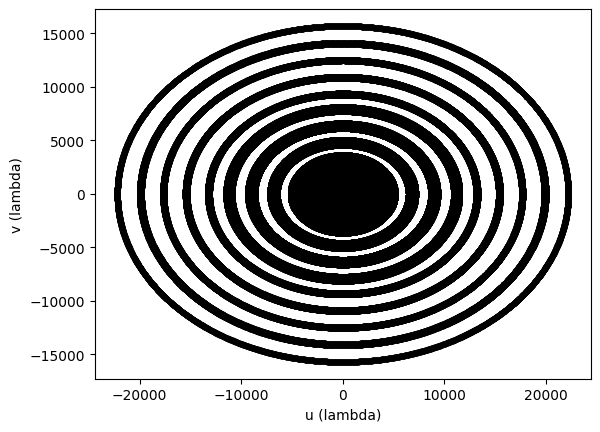

In [205]:
fig, ax = plt.subplots()
ax.scatter(UV_coverage[:, 0],UV_coverage[:,1], c="black", marker=".")
ax.set_xlabel('u ') 
ax.set_ylabel('v ')

In [206]:
np.max(fft.real)

127107823.0

In [ ]:
""" 
en este ejemplo, por lo que entiendo es que:
al estar en el plano u,v,w estamos midiendo la frecuencia espacial en el
espacio de fourier, por lo tanto,  como se estableció un limite maximo 
de medicion del espacio de fourier de 4000, solo podriamos muestriar hasta 
ese limite, lo que conlleva a que tenga que modificar el uvmax.
Esto me causa confusion ya que por ejemplo el valor maximo de frecuencia 
de la fft es 127107823.0, por lo tanto, ¿deberia ser siempre mi uvmax el valor
maximo de la fft de la imagen? o ¿existe alguna forma de poder calcular el valor
adecuado?
 """

In [207]:
#numero arbitrario de uvmax
uvgrid, sampling=grid_sampling(900,50000., UV_coverage)

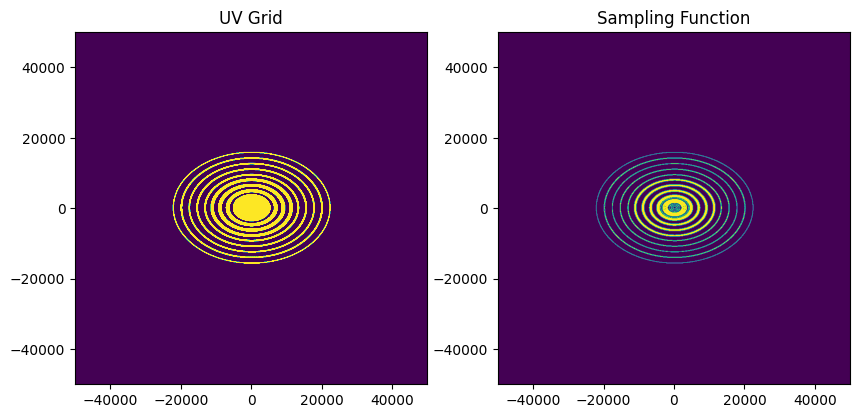

In [208]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('UV Grid');
plt.imshow(uvgrid.real, extent=[-50000,50000,-50000,50000], vmax=1)
plt.subplot(122)
plt.title('Sampling Function');
plt.imshow(sampling.real, extent=[-50000,50000,-50000,50000])

In [209]:
obs = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*sampling)))

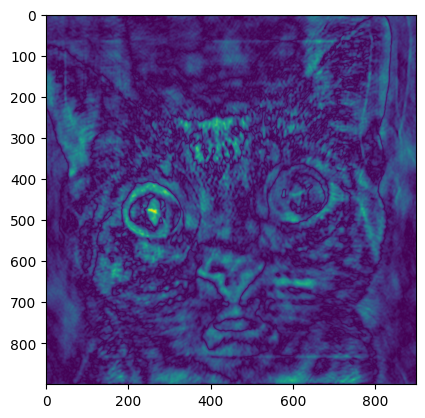

In [210]:
plt.imshow(obs)
plt.show()

# Ejemplo 3 VLA-D

In [211]:
vla_north = pd.read_csv('VLA_North.csv')
vla_swest = pd.read_csv('VLA_SWest.csv')
vla_seast = pd.read_csv('VLA_SEast.csv')

In [212]:
W = 1e-9*const_c*np.array(vla_swest)/wavelength
E = 1e-9*const_c*np.array(vla_seast)/wavelength
N = 1e-9*const_c*np.array(vla_north)/wavelength

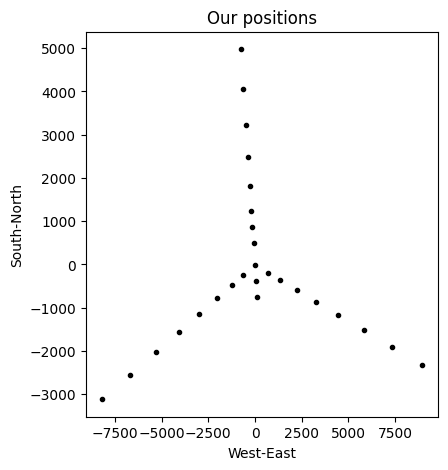

In [213]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Our positions') 
plt.xlabel('West-East') 
plt.ylabel('South-North')
plt.plot(W[:,1], -W[:,0], 'k.', E[:,1], -E[:,0], 'k.', N[:,1], -N[:,0], 'k.')

In [214]:
vla_d = np.vstack((vla_swest,vla_seast,vla_north))

In [216]:
# 1 horas de observación
HA, dec = h(1,45)
UV_coverage = coverage(baselines(vla_d), HA, dec)

Text(0, 0.5, 'v (lambda)')

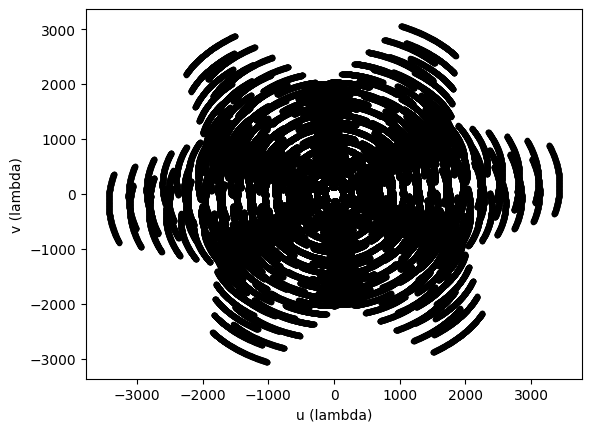

In [217]:
fig, ax = plt.subplots()
ax.scatter(UV_coverage[:, 0],UV_coverage[:,1], c="black", marker=".")
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [218]:

uvgrid, sampling=grid_sampling(900,4000., UV_coverage)

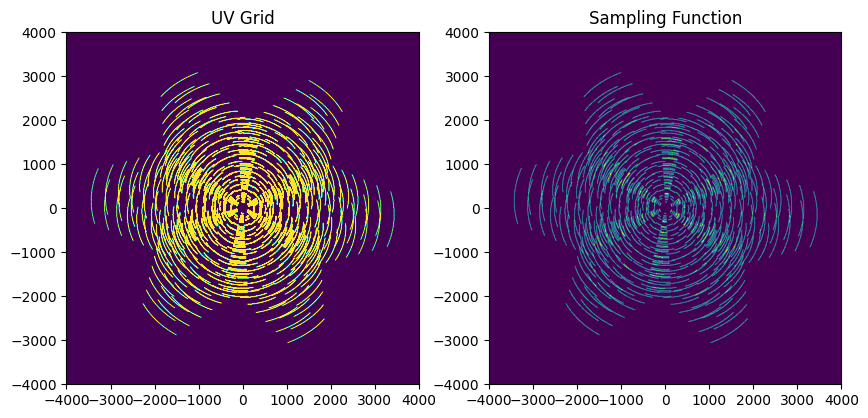

In [219]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('UV Grid');
plt.imshow(uvgrid.real, extent=[-4000,4000,-4000,4000], vmax=1)
plt.subplot(122)
plt.title('Sampling Function');
plt.imshow(sampling.real, extent=[-4000,4000,-4000,4000])

In [220]:
obs = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*sampling)))

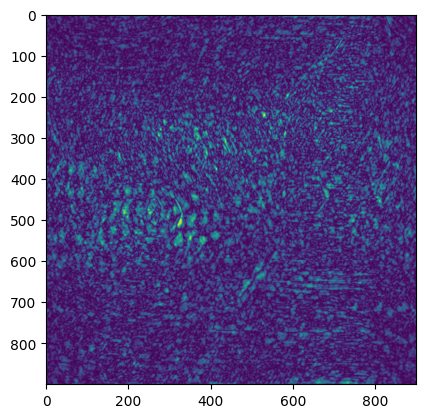

In [221]:
plt.imshow(obs)
plt.show()

In [ ]:
""" 
Para esta configración de antenas encontre que el simulador friendlyVRI igual lo posee
entonces hice comparaciones y me di cuenta que tiene delimitado el uvmax a aprox 206.000lambda
pero, en este simulador realizan el uv-coverage de manera distinta y por lo que comprendi utilizan
el uvmax a modo de escala para que el uv-coverage logre estar dentro del limite establecido.
En la carpeta hay imagenes que saque con dec=45; HA=-1 a 1

Repositorios interasantes que encontre:

https://github.com/ratt-ru/fundamentals_of_interferometry/tree/21d7754b273373adf161306f34aa920506d766a5


 """

In [222]:
uvgrid, sampling=grid_sampling(900,206265., UV_coverage)

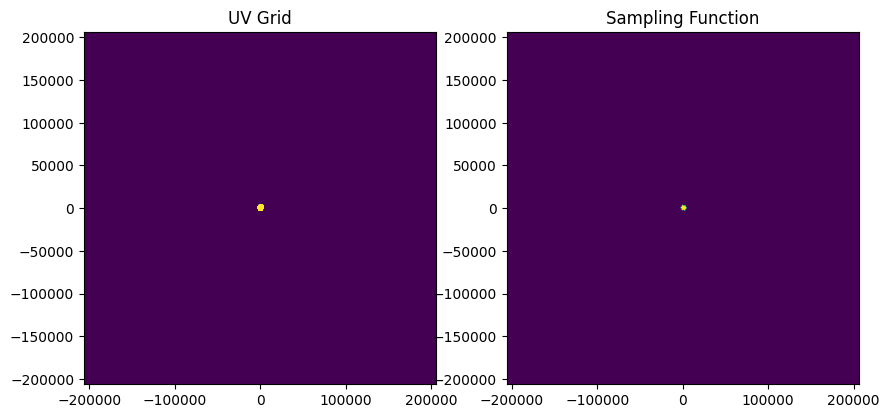

In [223]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('UV Grid');
plt.imshow(uvgrid.real, extent=[-206265,206265,-206265,206265], vmax=1)
plt.subplot(122)
plt.title('Sampling Function');
plt.imshow(sampling.real, extent=[-206265,206265,-206265,206265])

In [224]:
obs = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*sampling)))

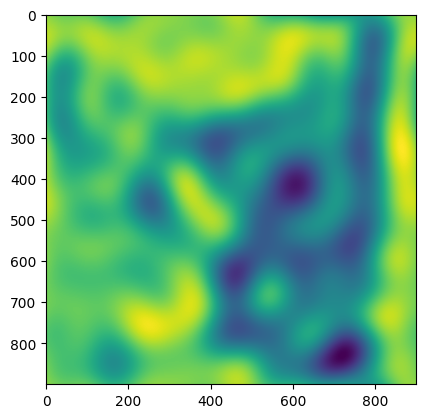

In [225]:
plt.imshow(obs)
plt.show()